#Notebook Lecture 5: LQG, Separation Principle, Stability Margins
@2025 ETH Zurich, Anna-Yaroslava Bodnar, Yunus Yazoglu, Aya Abrini, Livia Fischer; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

This interactive notebook will be a step by step guide on how to design an LQG controller for a biomedical ventilation system. Additionally, we will have a close look at the stability margins provided by LQR and LQG for this system.

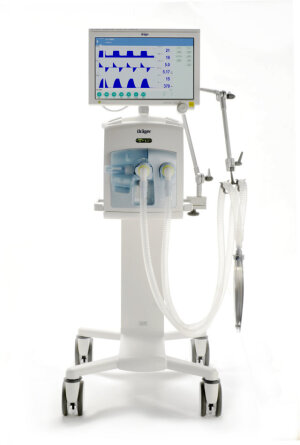

Image Source: https://www.dotmed.com/news/story/13285

Authors:
- Anna-Yaroslava Bodnar; abodnar@ethz.ch
- Yunus Yazoglu; yyazoglu@ethz.ch

Import the packages below:

In [1]:
!pip install numpy matplotlib ipywidgets scipy control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00


In [2]:
import numpy as np
from control import ss
from control import lqe
from control import nyquist_plot
from control.matlab import lsim
from control import input_output_response
from control import lqr
from control import forced_response
from control import ss2tf
from control import bode
from control import margin
import control
import matplotlib.pyplot as plt
from scipy import signal

# Step 1: Understanding and modelling biomedical ventilation systems

Medical ventilators are crucial for supporting patients that are not capable of breathing on their own. In this notebook we will take a closer look at Pressure-Controller Ventilation (PVC). We will simplify the patient-ventilator system to a SISO system. Our output y in this case would be the pressure in the air-ways of the patients lungs $P_{aw}$ and the control signal u will be the applied voltage $U_a$ to the motor of the ventilator.

To simplify the dynamics of the system, we can regard the ventilator as a piston connected to the lungs. If we do the system modelling (as this is not part of the course we will skip the equations), we would get a transfer function from $U_a$ to $P_{aw}$.


$$
\frac{P_{aw}}{U_a} = \frac{1074s + 4.297}{0.060642s^3 + 4.85s^2 + 1027.2795s + 0.24824}
$$


Using this transfer function, we can calculate the matrices A, B, C and D of the state space realization:


In [3]:
num = [1074, 4.297]  # Numerator coefficients
den = [0.060642, 4.85, 1027.2795, 0.24824]  # Denominator coefficients

A, B, C, D = signal.tf2ss(num, den)

print("State-space matrices:")
print("A:")
print(A)
print("B:")
print(B)
print("C:")
print(C)
print("D:")
print(D)


State-space matrices:
A:
[[-7.99775733e+01 -1.69400663e+04 -4.09353254e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]]
B:
[[1.]
 [0.]
 [0.]]
C:
[[    0.         17710.49767488    70.85848092]]
D:
[[0.]]


For the reference signal, we choose a square-wave oscillating between 0 and 1 V. The open loop system respone would be the following:

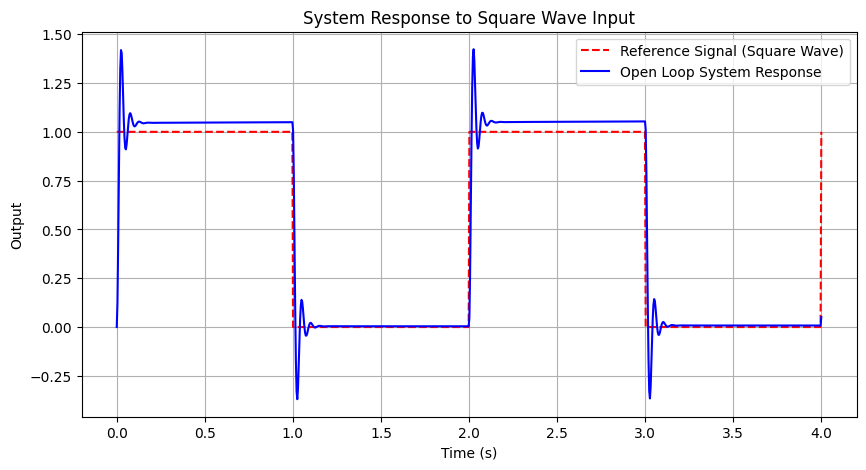

In [4]:
system = ss(A, B, C, D)

t = np.linspace(0, 4, 1000)

ref =  0.5 * (1 + signal.square(2 * np.pi * t / 2))

y_out, T, x_out = lsim(system, U=ref, T=t)

plt.figure(figsize=(10, 5))
plt.plot(t, ref, 'r--', label='Reference Signal (Square Wave)')
plt.plot(t, y_out, 'b-', label='Open Loop System Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('System Response to Square Wave Input')
plt.legend()
plt.grid()
plt.show()

We can see from the open loop system response, that we have unwanted oscillation and bad reference tracking. In the following we would like to design a LQG controller to avoid these issues and to provide a save system for the patient. Due to the seperation principle, we can design the controller and observer independently from each other and than combine them together for the LQG.

# Step 2: Solving the LQR Problem (without noise)

We will start first with designing the controller using LQR. As it is crucial for us to track the reference as good as possible, we need to include and LQR Servo. For that we need to include a new state space variable $\xi$ that describes the integrated error to the reference. Therefore we need to adjust the A,B,C and D matrices.

The new state space equations with the integrated error $\xi$ would be ($I$ would be the identity matrix, here it would be just 1):

$$
  \begin{bmatrix} \dot{x} \cr \dot{\xi} \end{bmatrix} = \begin{bmatrix} A  & \textbf{0} \cr C & 0 \end{bmatrix} \cdot \begin{bmatrix} x \cr \xi \end{bmatrix} + \begin{bmatrix} B \cr 0 \end{bmatrix} \cdot u +  \begin{bmatrix} \textbf{0} \cr I \end{bmatrix} r
$$

$$
  y = \begin{bmatrix} C & 0 \end{bmatrix} \cdot \begin{bmatrix} x \cr \xi \end{bmatrix} + D \cdot r
$$

We will use the new matrices from the state space above and plug them in into the LQR solver of the control library to get our K.

This would give us the following LQR state space equation:

For $u = - K \begin{bmatrix} x \cr \xi \end{bmatrix} $

$$
  \begin{bmatrix} \dot{x} \cr \dot{\xi} \end{bmatrix} = \begin{bmatrix} A - B \cdot K & \textbf{0} \cr C & 0 \end{bmatrix} \cdot \begin{bmatrix} x \cr \xi \end{bmatrix} +  \begin{bmatrix} \textbf{0} \cr I \end{bmatrix} r
$$

$$
  y = \begin{bmatrix} C & 0 \end{bmatrix} \cdot \begin{bmatrix} x \cr \xi \end{bmatrix} + D \cdot r
$$

For us the reference tracking is more important than the control effort. That is why we set the value inside the R matrix very low compared to the Q matrix.

We will calculate the K in the following code:

In [5]:
Q = np.diag([1, 1, 1,1])
R = np.array([[0.015*0.015]])

#LQR Servo:
A_s = np.block([[A, np.zeros((3,1))],
                [-C, np.zeros((1,1))]])

B_s = np.block([[B],
                [np.zeros((1,1))]])

C_LQR_s = np.block([C, np.zeros((1,1))])
D_LQR_s = D

# Solution of the LQR problem
K, _, E = control.lqr(A_s, B_s, Q, R)

print("Optimal feedback gain:", K)

# Closed-loop matrix
A_LQR_s = A_s - B_s @ K

B_LQR_s = np.block([[np.zeros((3,1))],
                 [1]])


Optimal feedback gain: [[  92.15008379 9393.53682934  101.26258778  -66.66666667]]


Now we can look how the square wave reference output of the new LQR Servo system compares to the open loop feedback with the following code:

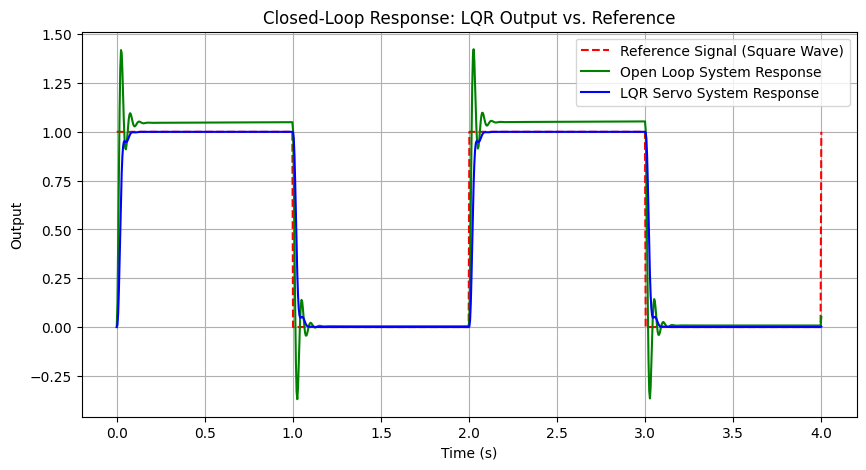

In [6]:
# Closed-loop system
sys_cl = ss(A_LQR_s, B_LQR_s, C_LQR_s, D_LQR_s)

# Q_r = np.diag([0.1, 0.1, 0.1])
# K_r, _, _ = lqr(A,B, Q_r, R)

# N = - np.linalg.inv(C @ np.linalg.inv(A - B @ K_r) @ B)
# sys_reference_sc = ss(A-B@K_r, B @ N, C, D)

# Transfer function
# tf = C @ np.linalg.inv(-A + B@K_r) @ B @ N
# print(tf)

# Get forced response
T_out_LQR, y_out_LQR = forced_response(sys_cl, T=t, U=ref)

#T_out_LQR_r, y_out_LQR_r = forced_response(sys_reference_sc, T=t, U=ref)

plt.figure(figsize=(10, 5))
plt.plot(t, ref, 'r--', label='Reference Signal (Square Wave)')
plt.plot(t, y_out, 'g-', label='Open Loop System Response')
plt.plot(t, y_out_LQR, 'b-', label='LQR Servo System Response')
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.title("Closed-Loop Response: LQR Output vs. Reference")
plt.legend()
plt.grid(True)
plt.show()

We see that with the LQR Servo we can perfectly align to the reference signal with zero steady state error and almost no oscillation compared to the open loop system.

#Step 3: Solving the LQE Problem



We can now design the Luenberger observer.

For the variance in the pressure measurement we assume a standart deviation of $\sigma_p = 0.01$ that we can plug into the R matrix. We can use the lqe function of the control library to calculate L.

In [7]:
Q = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])  # Process noise covariance (adjustable)

sigma_p = 0.01
R = np.array([[sigma_p*sigma_p]])  # Measurement noise covariance (adjustable)

L,_, E = lqe(A, np.eye(A.shape[0]),C, Q, R)

print("Kalman Gain (L):")
print(L)

print("Eigenvalues of Luenberger Observer:")
print(E)

Kalman Gain (L):
[[78.18266999]
 [99.6027686 ]
 [99.49587411]]
Eigenvalues of Luenberger Observer:
[-1.77106393e+06 -7.99766765e+01 -7.96267149e-01]


Know we would like to model the estimation of our output $\hat{P}_{aw}$. To see how resistant our Luenberger oberserver is, we need to also include the noise. We would also need to input our current measurement $\hat{P}_{aw}$ of our open loop system. Fortunately, we have already calculated that in the first step when looking at the open loop system response. We can feed that results in our Luenberger observer and add additional noise to that.

Our state space equation would be as following:

$$
  \dot{\hat{x}}= (A - L \cdot C)  \cdot  \hat{x} +  \begin{bmatrix} B & L \end{bmatrix} \cdot \begin{bmatrix} r \cr y_{noisy} \end{bmatrix}
$$

$$
  \hat{y} = C  \cdot \hat{x} + D \cdot \begin{bmatrix} r \cr y_{noisy} \end{bmatrix}
$$

We can simulate the $\hat{y}$ that we get from our observer and plot it:

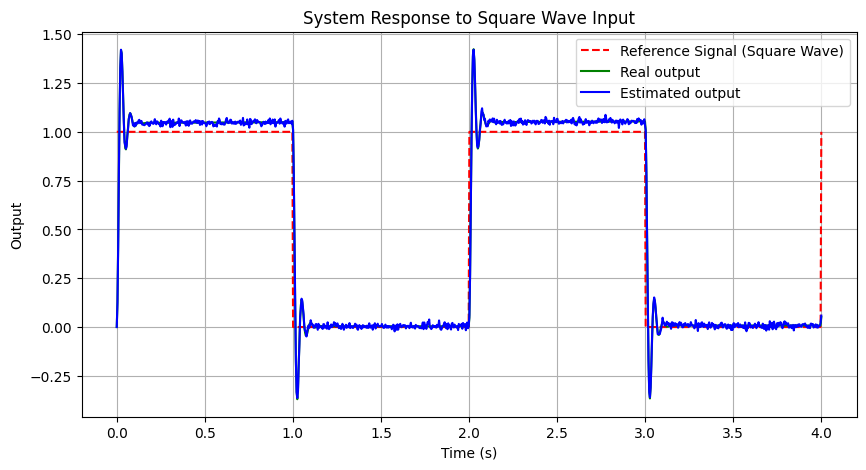

In [8]:
A_L = A - L @ C
B_L = np.block([B,L])
C_L = C
D_L = np.zeros((1,2))

system_L = ss(A_L, B_L, C_L, D_L)

y_out_noisy = y_out + np.random.normal(0, sigma_p, y_out.shape)
U_L = np.column_stack((ref, y_out_noisy))

y_out_L, T, x_out_L = lsim(system_L, U=U_L, T=t)

plt.figure(figsize=(10, 5))
plt.plot(t, ref, 'r--', label='Reference Signal (Square Wave)')
plt.plot(t, y_out, 'g-', label='Real output')
plt.plot(T, y_out_L, 'b-', label='Estimated output')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('System Response to Square Wave Input')
plt.legend()
plt.grid()
plt.show()

We see that although we have a noisy measurement, our estimated output $\hat{y}$ is very similar to the open loop response.

If you wonder why we look at the open loop response, look at the following diagram. We see that with the Luenberger observer we do not change the system dynamics (like we did in LQR by closing the loop) and that the input would be just our reference.

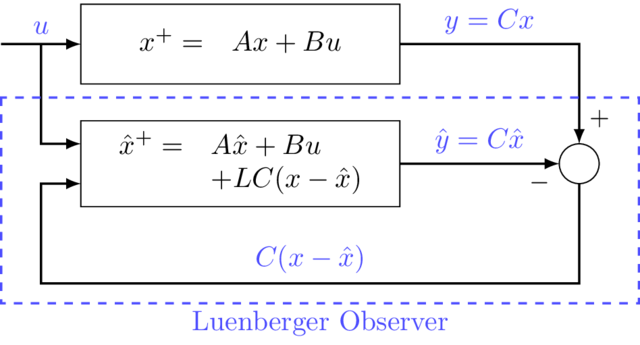

#Step 4: Combining Results of LQR and LQE together for LQG

Know we can take the estimated states from the Luenberger observer and feed them into the State Feedback of the LQR. This will result in the LQG. We will still include the integrated error (in the slides it would be $x_I$ ) to have a zero steady state feedback. Our integrated error would be the difference of the scaled reference and the estimated states.

We would also like to model the noise from our measurements. For that we will define an additional input $n$ which will model our measurement noise.

This will result in the following state space equations of the LQG (see slides for more information about the derivation). As the D matrix is zero, we can exclude it.

$$
  \begin{bmatrix} \dot{x} \cr \dot{x}_I \cr \dot{\hat{x}} \end{bmatrix} = \begin{bmatrix} A & - B \cdot K_I & -B \cdot K \cr -C & 0 & \textbf{0} \cr L \cdot C  & - B \cdot K_I  & A - B \cdot K - L \cdot C \end{bmatrix} \cdot \begin{bmatrix} x \cr x_I \cr \hat{x} \end{bmatrix} +  \begin{bmatrix} B K S & 0 \cr I & -1 \cr B K S & - L \end{bmatrix} \cdot \begin{bmatrix} r \cr n \end{bmatrix}
$$

$$
  y = \begin{bmatrix} C & 0 & \textbf{0} \end{bmatrix} \cdot \begin{bmatrix} x \cr x_I \cr \hat{x} \end{bmatrix}
$$

With that we can calculate the system response of our LQG to the square wave reference signal.

<ipython-input-9-b6076da79dcf>:26: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  U_L = np.row_stack((ref, noise))


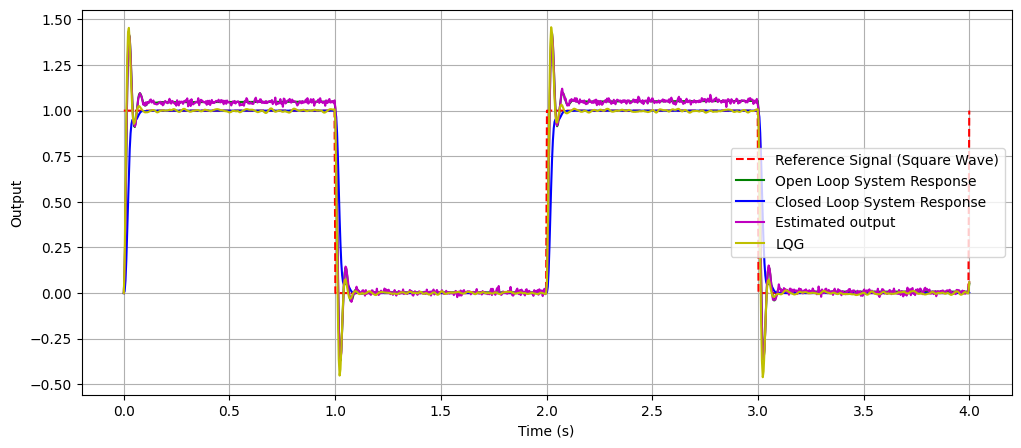

In [9]:
A_LQG_s = np.block([
    [        A,         -B*K[0][3] ,   -B @ [K[0][0:3]]],
    [-C, 0, np.zeros((1,3))],
    [     L@C,  - B*K[0][3] ,  A - B @ [K[0][0:3]] - L@C ]
])
# B_LQG = np.block([[B @ N], [B @ N]])
# C_LQG = np.hstack([C, np.zeros((C.shape[0], A_LQG.shape[0]//2))])
# D_LQG = D

#determine reference scaling
N_bar = - np.linalg.inv(C @ np.linalg.inv(A - B @ [K[0][0:3]]) @ B)

S = np.linalg.pinv(K) @ N_bar

B_LQG_s = np.block([[B @ K @ S, np.zeros((3,1))],
                    [1, -1],
                    [B @ K @ S, -L]])

C_LQG_s = np.block([[C, np.zeros((1,4))]])

D_LQG_s = np.zeros((1,2))

sys_lqg = ss(A_LQG_s, B_LQG_s, C_LQG_s, D_LQG_s)

noise = np.random.normal(0, sigma_p, y_out.shape)
U_L = np.row_stack((ref, noise))

t_out_LQG, y_out_LQG = control.forced_response(sys_lqg, T=t, U=U_L, X0=0)

plt.figure(figsize=(12, 5))
plt.plot(t, ref, 'r--', label='Reference Signal (Square Wave)')
plt.plot(t, y_out, 'g-', label='Open Loop System Response')
plt.plot(t, y_out_LQR, 'b-', label='Closed Loop System Response')
plt.plot(t, y_out_L, 'm-', label='Estimated output')
plt.plot(t, y_out_LQG[0], 'y', label='LQG')
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.title("")
plt.legend()
plt.grid(True)
plt.show()

We see that although our controller oscillate less, our LQG system is less stable.

# Step 5: Stability Margins



## Nyquist Plot

We will look now at the stability margins of our LQG system. For that we did a Bode plot and we see that it does not have the same guarantees given as the LQR System. Always check the stability margins of the LQG before using it!

There is not guarantee given like in LQR.

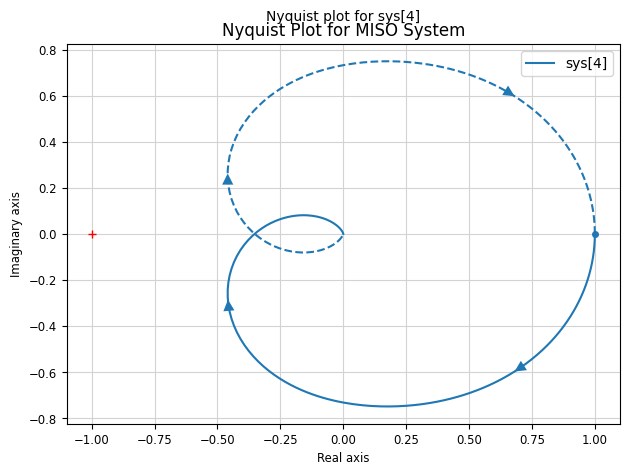

In [10]:
#Nyquist Plots

sys_LQR = control.ss(A_LQR_s, B_LQR_s, C_LQR_s, D_LQR_s)

# Convert to transfer function (G1: first input, G2: second input)
#sys_tf = control.ss2tf(sys_ss)

# Generate Nyquist plot for each input separately
plt.figure()
control.nyquist(sys_LQR)
plt.title("Nyquist Plot for MISO System")
plt.legend()
plt.show()

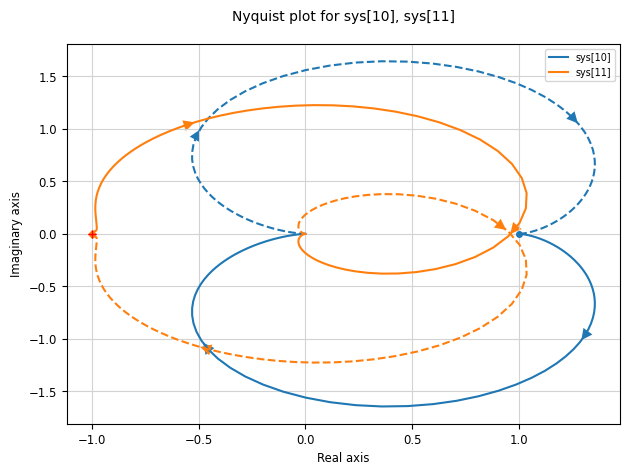

In [11]:
#Nyquist Plots

sys_ss_r = control.ss(A_LQG_s, B_LQG_s, C_LQG_s, D_LQG_s)
sys_ss_reference = control.ss(A_LQG_s, B_LQG_s[:,0].reshape(-1,1), C_LQG_s, D)
sys_ss_noise = control.ss(A_LQG_s, B_LQG_s[:,1].reshape(-1,1), C_LQG_s, D)

control.nyquist(sys_ss_reference)
control.nyquist(sys_ss_noise)


# # Convert to transfer function (G1: first input, G2: second input)
# sys_tf = control.ss2tf(sys_ss_noise)

# # Extract individual transfer functions
# G1 = sys_tf[0]  # First input -> output
# G2 = sys_tf[1]  # Second input -> output

# # Generate Nyquist plot for each input separately
# plt.figure()
# # control.nyquist(G1, label="Input 1 → Output")
# # control.nyquist(G2, label="Input 2 → Output")
# plt.title("Nyquist Plot for MISO System")
# plt.legend()
# plt.show()

In blue you see the nyquist plot of the reference input for the LQG system and
in orange you see the one for the noise.

## Bode Plot

Below, we take our **plant** (the original system) and our **LQG controller** and form the open-loop transfer function. We then generate a Bode plot of this open-loop transfer function to exmaine how the system behaves across different frequencies, focusing on **gain margin** and **phase margin**.


(1, 4)


/usr/local/lib/python3.11/dist-packages/control/config.py:363: FutureWarning: keyword 'margins' is deprecated; use 'display_margins'
  warnings.warn(


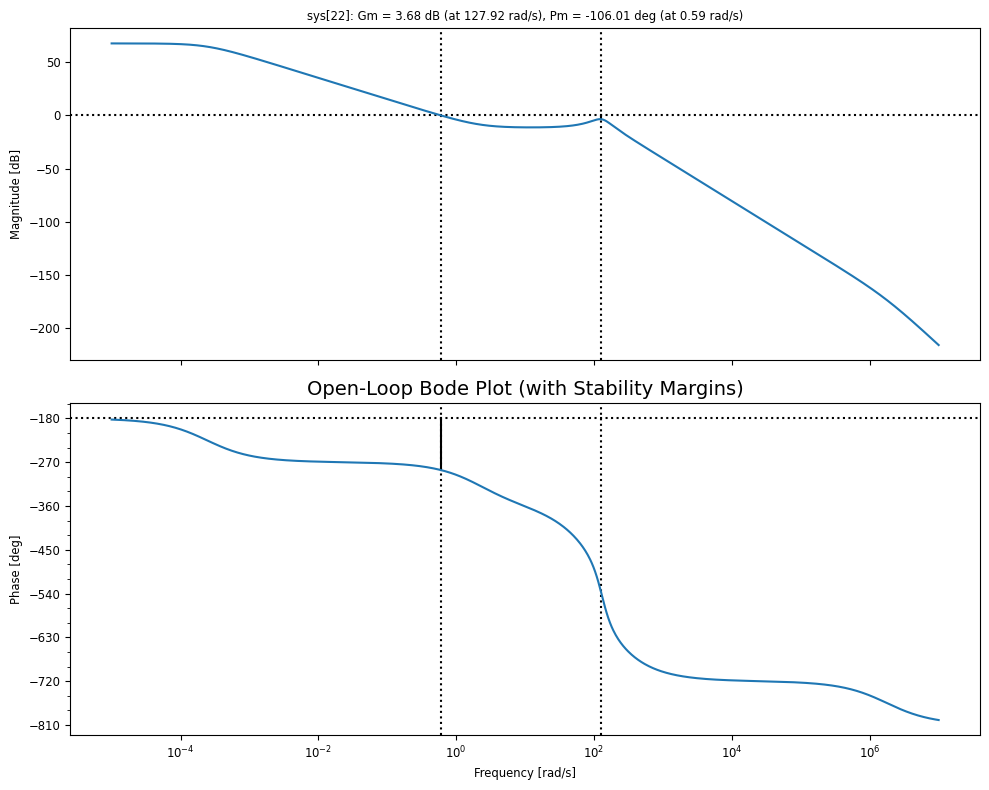

Gain margin = 1.53 at ω = 127.92 rad/s
Phase margin = -106.01 deg at ω = 0.59 rad/s


In [12]:
Plant = ss(A, B, C, D)


print(K.shape)

# Controllers state space matrices:
A_c = A - B @ K[:, :3] - L @ C
B_c = L
C_c = - K[:, :3]
D_c = D

# Convert controller to its transfer function representation
K_Controller = control.ss(A_c, B_c, C_c, D_c)

# Loop = Controller TF * Plant TF
Loop = control.series(Plant, K_Controller)

w = np.logspace(-2, 2, 500)
plt.figure(figsize=(10, 8))
control.bode_plot(Loop, dB=True, margins=True)
#plt.xlim([w[0], 10**5])
plt.title("Open-Loop Bode Plot (with Stability Margins)", fontsize=14)
plt.show()

gm, pm, sm, wg, wp, ws = control.stability_margins(Loop)
print(f"Gain margin = {gm:.2f} at ω = {wg:.2f} rad/s")
print(f"Phase margin = {pm:.2f} deg at ω = {wp:.2f} rad/s")

In the displayed results above, the system has:


*   A **positive gain margin**, which indicates that the system can tolerate an incerase in gain upt o a certain limit before reaching instability.
*  A **negative phase margin**, which indicates that at the gain crossover frequency, the phase has already passed $-180^\circ$. In classical control theory, this typically implies that the closed-loop system would be unstable.

This contrast underscores the importance of double-checking stability margins when using LQG controllers and not blindly trusting LQG.
